# Data Sources

Get data 

## import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

## definitions

In [2]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))
ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2023-01-01 00:00:00"
LAST_DATE =  "2024-06-29 16:15:00" # "2023-12-16 23:45:00"
TIMEFRAME = "5m"
PATH_DATA = "data"
path_save_df_eth = "data/df_eth_05m.csv"
path_save_df_eth_2 = "data/df_eth_2_05m.csv"
path_save_df_btc = "data/df_btc_05m.csv"
path_save_df_btc_2 = "data/df_btc_2_05m.csv"
path_save_df_bnb = "data/df_bnb_05m.csv"
path_save_df_bnb_2 = "data/df_bnb_2_05m.csv"
path_save_df_eco = "data/df_eco.csv"
path_save_df_feat = "data/df_features_05m.csv"

# CCXT crypto exchanges declaration
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

kucoin = ccxt.kucoin({
    'rateLimit': 1,
    'enableRateLimit': True,
})

DICT_COINGECKO = {
    "BTC": "bitcoin",
    "ETH": "ethereum",
}


In [3]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

## Download data

In [4]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE

# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp, params= { 'until': to_timestamp})
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            timeframe_ms = int((last - first) / (len(ohlcvs)-1))
            from_timestamp += len(ohlcvs) * timeframe_ms
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms') # -> date object
    df['date'] = df['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except AssertionError as error:
        print(error)
        return False




    
def req_ohlcv_all(exchange, first_date=FIRST_DATE, last_date=LAST_DATE):

    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        first_date,  
        last_date,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    return df_eth, df_btc, df_bnb

def merge_ohlcv_data(df_old, df_new):

    # Merge old with new data 
    df = pd.concat([df_old, df_new], ignore_index=True)
    print("df_old.shape: ", df_old.shape)
    print("df_new.shape: ", df_new.shape)
    print("Before : df.shape: ", df.shape)
    df = df.drop_duplicates(
        subset=["date"], keep="last", ignore_index=True)
    print("After : df.shape: ", df.shape)
    return df



def get_ohlcv_all(exchange, path_save_df_eth, path_save_df_btc, path_save_df_bnb):
    """
    Get prices from disk and from exchange if update needed
    """
    # reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)
    
    return df_eth, df_btc, df_bnb

In [5]:
data_ok = check_data()
print(data_ok)

if not data_ok:
    
    df_eth, df_btc, df_bnb = req_ohlcv_all(exchange)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:

    df_eth, df_btc, df_bnb = get_ohlcv_all(
        exchange,
        path_save_df_eth,
        path_save_df_btc,
        path_save_df_bnb
    )
    '''# reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)'''
        

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

True
Reload data binance exchange from disk...
New data to download...
1719678854236 Fetching candles starting from 2024-06-14T06:15:00.000Z
1719678858291 Fetched 500 candles
First candle epoch 1718345700000 2024-06-14T06:15:00.000Z
Last candle epoch 1718495400000 2024-06-15T23:50:00.000Z
1719678858291 Fetching candles starting from 2024-06-15T23:55:00.000Z
1719678858691 Fetched 500 candles
First candle epoch 1718495700000 2024-06-15T23:55:00.000Z
Last candle epoch 1718645400000 2024-06-17T17:30:00.000Z
1719678858691 Fetching candles starting from 2024-06-17T17:35:00.000Z
1719678859241 Fetched 500 candles
First candle epoch 1718645700000 2024-06-17T17:35:00.000Z
Last candle epoch 1718795400000 2024-06-19T11:10:00.000Z
1719678859241 Fetching candles starting from 2024-06-19T11:15:00.000Z
1719678859534 Fetched 500 candles
First candle epoch 1718795700000 2024-06-19T11:15:00.000Z
Last candle epoch 1718945400000 2024-06-21T04:50:00.000Z
1719678859535 Fetching candles starting from 2024-06-

In [6]:
pd.read_csv(path_save_df_eth)

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
157134,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00
157135,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00
157136,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00
157137,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00


In [7]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
157134,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00
157135,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00
157136,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00
157137,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00


In [8]:
test_time_continuity(df_eth)

Time gap!


False

In [9]:

data_ok_2 = check_data_2()

if not data_ok_2:

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    print("Reload data kucoin exchange from disk...")

    df_eth_2, df_btc_2, df_bnb_2 = get_ohlcv_all(
        exchange,
        path_save_df_eth_2,
        path_save_df_btc_2,
        path_save_df_bnb_2,
    )
    '''# reload from disk
    
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False) 
    '''

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
Reload data binance exchange from disk...
New data to download...
1719678871312 Fetching candles starting from 2024-06-14T06:15:00.000Z
1719678871488 Fetched 500 candles
First candle epoch 1718345700000 2024-06-14T06:15:00.000Z
Last candle epoch 1718495400000 2024-06-15T23:50:00.000Z
1719678871489 Fetching candles starting from 2024-06-15T23:55:00.000Z
1719678871906 Fetched 500 candles
First candle epoch 1718495700000 2024-06-15T23:55:00.000Z
Last candle epoch 1718645400000 2024-06-17T17:30:00.000Z
1719678871906 Fetching candles starting from 2024-06-17T17:35:00.000Z
1719678872308 Fetched 500 candles
First candle epoch 1718645700000 2024-06-17T17:35:00.000Z
Last candle epoch 1718795400000 2024-06-19T11:10:00.000Z
1719678872308 Fetching candles starting from 2024-06-19T11:15:00.000Z
1719678872719 Fetched 500 candles
First candle epoch 1718795700000 2024-06-19T11:15:00.000Z
Last candle epoch 1718945400000 2024-06-21T04:50:00.000Z
1719678872720 Fet

In [10]:
df_eth_2

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.21,1196.22,1195.53,1196.14,64.898071,2023-01-01 00:00:00
1,1672531500000,1196.22,1196.51,1195.06,1195.30,65.407549,2023-01-01 00:05:00
2,1672531800000,1195.30,1195.65,1194.56,1194.56,53.841561,2023-01-01 00:10:00
3,1672532100000,1194.41,1195.98,1194.31,1195.88,31.516025,2023-01-01 00:15:00
4,1672532400000,1195.87,1196.41,1195.87,1195.98,13.723162,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.703800,2024-06-29 15:55:00
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.204300,2024-06-29 16:00:00
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.847700,2024-06-29 16:05:00
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.224800,2024-06-29 16:10:00


In [11]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
157134,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00
157135,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00
157136,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00
157137,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00


In [12]:
assert df_eth["Time"].values[0] == df_eth_2["Time"].values[0], "Time reference (first) must be the same!"

In [13]:
def get_unique(df_):
    d_time = np.diff(df_["Time"].values)
    #np.max(d_time) == np.min(d_time)
    unique_val, unique_inv, unique_counts = np.unique(d_time, return_inverse=True, return_counts=True)
    print(unique_val)
    print(unique_counts)
    print(unique_inv)
    return unique_val, unique_counts, unique_inv

In [14]:
a,b,c = get_unique(df_eth)

[ 300000  600000 5100000]
[157136      1      1]
[0 0 0 ... 0 0 0]


In [15]:
c==4

array([False, False, False, ..., False, False, False])

In [16]:
#df_eth.Time[c==4]

In [17]:
d_time = np.diff(df_eth["Time"].values)
#np.max(d_time) == np.min(d_time)
unique_val, unique_counts = np.unique(d_time, return_counts=True)
print(unique_val)
print(unique_counts)

[ 300000  600000 5100000]
[157136      1      1]


In [18]:
d_time = np.diff(df_eth_2["Time"].values)
#np.max(d_time) == np.min(d_time)
unique_val, unique_index, unique_counts = np.unique(d_time, return_index=True, return_counts=True)
print(unique_val)
print(unique_counts)
unique_index

[300000]
[157155]


array([0])

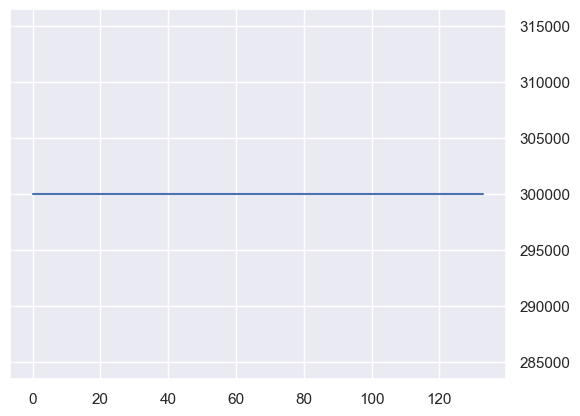

In [19]:
plt.plot(np.diff(df_eth["Time"].values[-135:]))

In [20]:
df_eth["date"].iloc[-135:].head(10)

157004    2024-06-29 05:05:00
157005    2024-06-29 05:10:00
157006    2024-06-29 05:15:00
157007    2024-06-29 05:20:00
157008    2024-06-29 05:25:00
157009    2024-06-29 05:30:00
157010    2024-06-29 05:35:00
157011    2024-06-29 05:40:00
157012    2024-06-29 05:45:00
157013    2024-06-29 05:50:00
Name: date, dtype: object

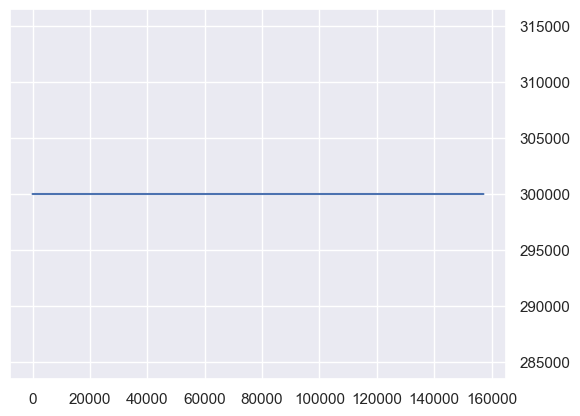

In [21]:
plt.plot(np.diff(df_eth_2["Time"].values))

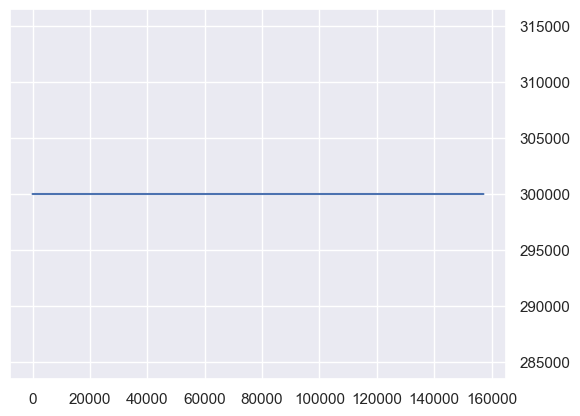

In [22]:
plt.plot(np.diff(df_eth_2["Time"].values))

In [23]:
test_time_continuity(df_eth)

Time gap!


False

In [24]:
test_time_continuity(df_eth_2)

True

In [25]:
def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

In [26]:
def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missing dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df

In [27]:
def fill_time_gap_interp(df_in, df_2):
    """
    Imputation of ohlcv CCTX nan data : 
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin) 
        So we use all prices of kucoin for missing dates
        Also, we add estimate unkonwn binance volumes in proportion of previous 
        "hour" known volumes from the two exchanges.

    If kucoin have also time gap ! OMG!
        So we use all prices of kucoin for missing dates
        If also Nan for kucoin, we interpolate (linear) binance data with Binance data only
        Nan & Zero volumes are interpolate also (unlike former fill_time_gap...) with Binance data only
    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            #raise Exception("Error good input data 2")

            # two exchanges have nan values !!! OMG!!!
            # use interpolate
            df, l_index = add_nb_time(df)
            df_2, l_index_2 = add_nb_time(df_2)
            new_index = np.array(range(max(df["nb_time"])+1))
            df = df.reindex(new_index)
            df_2 = df_2.reindex(new_index)
            df_mix = df.join(df_2, rsuffix='_2')
            b_nan = df_mix["Open"].isna()
            df_mix.loc[b_nan, "Open"] = df_mix.loc[b_nan, "Open_2"]
            df_mix.loc[b_nan, "High"] = df_mix.loc[b_nan, "High_2"]
            df_mix.loc[b_nan, "Low"] = df_mix.loc[b_nan, "Low_2"]
            df_mix.loc[b_nan, "Close"] = df_mix.loc[b_nan, "Close_2"]
            df_mix.loc[b_nan, "Time"] = df_mix.loc[b_nan, "Time_2"]
            df_mix.loc[b_nan, "date"] = df_mix.loc[b_nan, "date_2"]
            df_mix.loc[b_nan, "nb_time"] = df_mix.loc[b_nan, "nb_time_2"]

            # special volume zero :
            df_mix.loc[df_mix["Volume"] <= 0, "Volume"] = np.nan

            # interpolate 
            df_mix["Open"] = df_mix["Open"].interpolate()
            df_mix["High"] = df_mix["High"].interpolate()
            df_mix["Low"] = df_mix["Low"].interpolate()
            df_mix["Close"] = df_mix["Close"].interpolate()
            df_mix["Volume"] = df_mix["Volume"].interpolate()
            df_mix["Time"] = df_mix["Time"].interpolate()
            df_mix["nb_time"] = df_mix["nb_time"].interpolate()

            # Date
            df_mix['date'] = pd.to_datetime(df_mix['Time'], unit='ms') # -> date object
            df_mix['date'] = df_mix['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

            # keep good col only
            # Time	Open	High	Low	Close	Volume	date	nb_time
            df_mix = df_mix[["Time",	"Open",	"High",	"Low",	
                            "Close",	"Volume",	"date",	"nb_time"]]
            
            if not test_time_continuity(df_mix):
                raise Exception("Error no good interpolated data")
            return df_mix

    else:
        return df

In [28]:
#df_eth = fill_time_gap(df_eth, df_eth_2)
#df_btc = fill_time_gap(df_btc, df_btc_2)
#df_bnb = fill_time_gap(df_bnb, df_bnb_2)

df_eth = fill_time_gap_interp(df_eth, df_eth_2)
df_btc = fill_time_gap_interp(df_btc, df_btc_2)
df_bnb = fill_time_gap_interp(df_bnb, df_bnb_2)

Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume index 23774
Correcting volume index 23775
Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume in

In [29]:
test_time_continuity(df_eth) and test_time_continuity(df_btc) and test_time_continuity(df_bnb) 

True

In [30]:
df_btc

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00
1,1672531500000,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00
2,1672531800000,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00
3,1672532100000,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00
4,1672532400000,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
157151,1719676500000,61070.01,61106.00,61068.57,61106.00,19.80697,2024-06-29 15:55:00
157152,1719676800000,61106.00,61124.00,61079.62,61091.14,42.38193,2024-06-29 16:00:00
157153,1719677100000,61091.14,61091.14,61066.35,61068.17,25.02100,2024-06-29 16:05:00
157154,1719677400000,61068.17,61068.17,61018.22,61018.23,20.01062,2024-06-29 16:10:00


In [31]:
"""b_last = df_btc["date"] > "2023-04-18 04:00:00"
fig = plt.figure(figsize=(12, 8))
plt.plot(df_btc[b_last]["date"], df_btc[b_last]["Volume"])
plt.xticks(rotation=90)
plt.title("Volume BTC binance")"""

'b_last = df_btc["date"] > "2023-04-18 04:00:00"\nfig = plt.figure(figsize=(12, 8))\nplt.plot(df_btc[b_last]["date"], df_btc[b_last]["Volume"])\nplt.xticks(rotation=90)\nplt.title("Volume BTC binance")'

## Merge everything

In [32]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)


In [33]:
# df_feat 
df_feat = df_eth.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

df_feat.shape

(157156, 19)

In [34]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,61070.01,61106.00,61068.57,61106.00,19.80697,2024-06-29 15:55:00,572.3,572.6,572.1,572.6,182.022,2024-06-29 15:55:00
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,61106.00,61124.00,61079.62,61091.14,42.38193,2024-06-29 16:00:00,572.5,572.6,572.3,572.4,196.986,2024-06-29 16:00:00
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,61091.14,61091.14,61066.35,61068.17,25.02100,2024-06-29 16:05:00,572.5,572.6,572.2,572.3,108.733,2024-06-29 16:05:00
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,61068.17,61068.17,61018.22,61018.23,20.01062,2024-06-29 16:10:00,572.3,572.6,571.8,571.8,630.111,2024-06-29 16:10:00


## Save (unactived)

In [35]:
#path_save_df_feat

In [36]:
#df_feat.to_csv(path_save_df_feat, index=False)

## Add price action indicators

Ichimoku 1h 1D 1W

In [37]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_a_week"].ffill(inplace=True)
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()
    
    return df_out

df_eth = add_ichimoku(df_eth)
df_btc = add_ichimoku(df_btc)

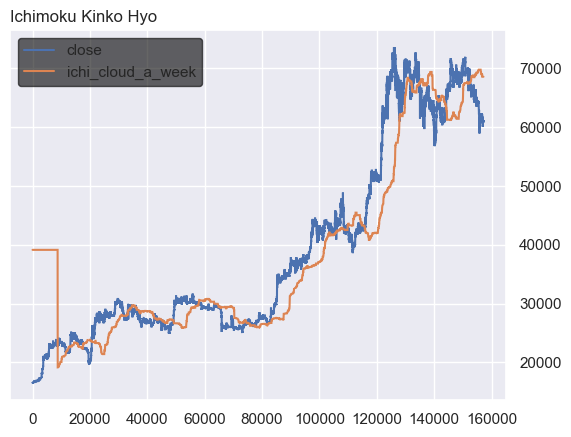

In [38]:
plt.plot(df_btc.Close, label="close")
plt.plot(df_btc["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

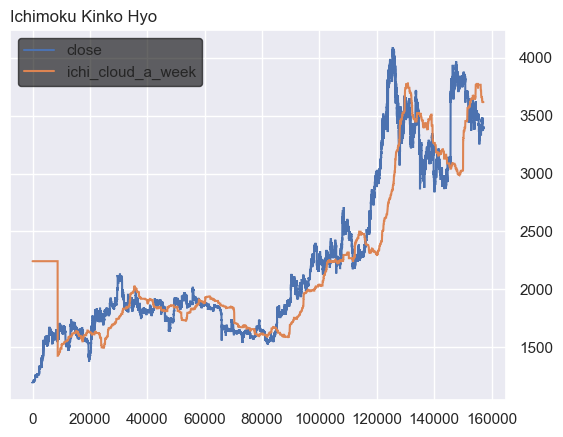

In [39]:
plt.plot(df_eth.Close, label="close")
plt.plot(df_eth["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

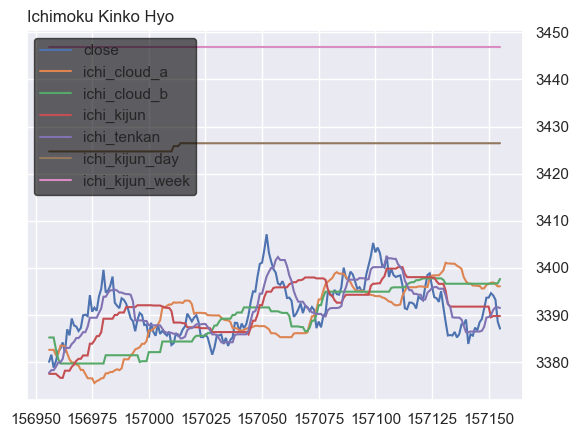

In [40]:
plt.plot(df_eth[-200:].Close, label="close")
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [41]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df, n=14):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=n).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=n*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=n*24*7).rsi()
    return df_out


df_eth = add_rsi(df_eth)
df_btc = add_rsi(df_btc)
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,2226.855765,NaN,NaN,2243.202229,2186.297212,NaN,NaN,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,2226.855765,NaN,NaN,2243.202229,2186.297212,NaN,NaN,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,2226.855765,NaN,NaN,2243.202229,2186.297212,NaN,NaN,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,2226.855765,NaN,NaN,2243.202229,2186.297212,NaN,NaN,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,2226.855765,NaN,NaN,2243.202229,2186.297212,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,3380.725000,3426.46,3388.525,3616.247500,3431.905000,3446.895,3365.07,58.433110,49.125005,49.371651
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,3380.725000,3426.46,3388.525,3616.247500,3431.905000,3446.895,3365.07,62.360452,49.265883,49.386408
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,3380.725000,3426.46,3388.525,3616.247500,3431.905000,3446.895,3365.07,56.032301,49.114476,49.370429
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,3380.725000,3426.46,3388.525,3616.247500,3431.905000,3446.895,3365.07,52.793784,49.029644,49.361461


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [42]:
# add CHOP indicator on 1hour 1day 1week 
def add_chop(df, n):
    df_out = df.copy()

    def calculate_chop(df, n, k):
        #(high: pandas.core.series.Series, 
        # low: pandas.core.series.Series, 
        # close: pandas.core.series.Series, 
        # window: int = 14, 
        # fillna: bool = False)
        atr = AverageTrueRange(
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            window=1*k,
            ).average_true_range()
        sum_atr = atr.rolling(n*k).sum()
        max_high = df_out["High"].rolling(n*k).max()
        min_low = df_out["Low"].rolling(n*k).min()
        chop = 100 * np.log10(sum_atr / (max_high - min_low )) / np.log10(n*k)
        return chop, atr, max_high, min_low
    
    
    def  add_chop_col(df_out, n, k):
        chop, atr, max_high, min_low = calculate_chop(df_out, n, k)
        if k == 1:
            df_out["max_high_h"] = max_high
            df_out["min_low_h"] = min_low
            df_out["atr_h"] = atr
            df_out["chop_h"] = chop
        elif (k==24):
            df_out["max_high_d"] = max_high
            df_out["min_low_d"] = min_low
            df_out["atr_d"] = atr
            df_out["chop_d"] = chop   
        elif (k==24*7):
            df_out["max_high_w"] = max_high
            df_out["min_low_w"] = min_low
            df_out["atr_w"] = atr
            df_out["chop_w"] = chop  
        else:
            df_out[f"max_high_{k}"] = max_high
            df_out[f"min_low_{k}"] = min_low
            df_out[f"atr_{k}"] = atr
            df_out[f"chop_{k}"] = chop
        return df_out                       
    # 1h
    df_out = add_chop_col(df_out, n, 1)
    # 1day
    df_out = add_chop_col(df_out, n, 24)    
    # 1week
    df_out = add_chop_col(df_out, n, 24*7)

    return df_out

df_eth = add_chop(df_eth, 14)
df_btc = add_chop(df_btc, 14)
df_eth[["date", "High", "Low", "Close", 
         "atr_h", "max_high_h","min_low_h", "chop_h",
         "atr_d", "max_high_d","min_low_d", "chop_d",
         "atr_w", "max_high_w","min_low_w", "chop_w"]].tail(30)


,date,High,Low,Close,atr_h,max_high_h,min_low_h,chop_h,atr_d,max_high_d,min_low_d,chop_d,atr_w,max_high_w,min_low_w,chop_w
157126,2024-06-29 13:50:00,3396.02,3393.76,3393.76,2.26,3400.53,3390.00,50.762015,2.591276,3476.73,3365.22,44.912101,3.644143,3547.55,3240.0,49.127956
157127,2024-06-29 13:55:00,3395.17,3392.50,3393.55,2.67,3400.53,3390.00,48.559537,2.594556,3476.73,3365.22,44.892232,3.638344,3547.55,3240.0,49.124562
157128,2024-06-29 14:00:00,3393.99,3390.60,3392.78,3.39,3400.53,3390.60,51.953148,2.627700,3476.73,3365.22,44.872925,3.636866,3547.55,3240.0,49.121160
157129,2024-06-29 14:05:00,3395.86,3392.79,3395.06,3.08,3400.53,3390.60,53.332240,2.646546,3476.73,3365.22,44.853980,3.633552,3547.55,3240.0,49.117753
157130,2024-06-29 14:10:00,3395.07,3391.66,3391.67,3.41,3400.53,3390.60,54.427710,2.678356,3476.73,3365.22,44.836308,3.632221,3547.55,3240.0,49.114332
157131,2024-06-29 14:15:00,3392.35,3387.81,3388.53,4.54,3400.53,3387.81,47.563602,2.755925,3476.73,3365.22,44.819605,3.637624,3547.55,3240.0,49.110901
157132,2024-06-29 14:20:00,3388.52,3384.19,3385.64,4.34,3400.53,3384.19,39.408498,2.821928,3476.73,3365.22,44.803488,3.641805,3547.55,3240.0,49.107479
157133,2024-06-29 14:25:00,3387.07,3383.00,3385.73,4.07,3400.53,3383.00,36.258054,2.873931,3476.73,3365.22,44.788636,3.644354,3547.55,3240.0,49.104062
157134,2024-06-29 14:30:00,3388.77,3385.01,3385.62,3.76,3400.53,3383.00,36.307836,2.910850,3476.73,3365.22,44.774956,3.645042,3547.55,3240.0,49.100630
157135,2024-06-29 14:35:00,3387.34,3384.33,3386.39,3.01,3400.53,3383.00,37.435132,2.914982,3476.73,3365.22,44.762188,3.641262,3547.55,3240.0,49.097190


VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price

In [43]:
# VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# VolumeWeightedAveragePrice(high: pandas.core.series.Series,
# low: pandas.core.series.Series, 
# close: pandas.core.series.Series, 
# volume: pandas.core.series.Series, 
# window: int = 14, 
# fillna: bool = False)
# volume_weighted_average_price
def add_vwap(df, n=1):
    df_out = df.copy()
    # 1hour
    df_out["vwap_h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=14,
        fillna=True,
        ).volume_weighted_average_price()
    # 1day
    df_out["vwap_d"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24).volume_weighted_average_price()    
    # 1week
    df_out["vwap_w"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7).volume_weighted_average_price() 
    # 1month
    df_out["vwap_m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30).volume_weighted_average_price() 
    # 3months
    df_out["vwap_3m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*3).volume_weighted_average_price() 
    # 6months
    df_out["vwap_6m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*6).volume_weighted_average_price() 
    # 1year
    df_out["vwap_y"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*24*365,
        fillna=True,
        ).volume_weighted_average_price()
    # all time
    df_out["vwap_all"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=df_out.shape[0],
        fillna=True,
        ).volume_weighted_average_price()
    return df_out


df_eth = add_vwap(df_eth)
df_btc = add_vwap(df_btc)
df_eth


,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,atr_w,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,0.000000,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,0.000000,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,0.000000,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,0.000000,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,0.000000,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,3.538341,49.041038,3389.438395,3388.456986,3393.164211,3471.854215,3514.715949,3380.893042,3572.893985,2279.405025
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,3.534720,49.037469,3390.007587,3388.499120,3393.146869,3471.842182,3514.723763,3380.883429,3572.871474,2279.406385
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,3.525644,49.033862,3390.442564,3388.355316,3393.139641,3471.833316,3514.753495,3380.877141,3572.809098,2279.407398
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,3.532337,49.030183,3390.528933,3388.326147,3393.134969,3471.808979,3514.758865,3380.872307,3572.790182,2279.408521


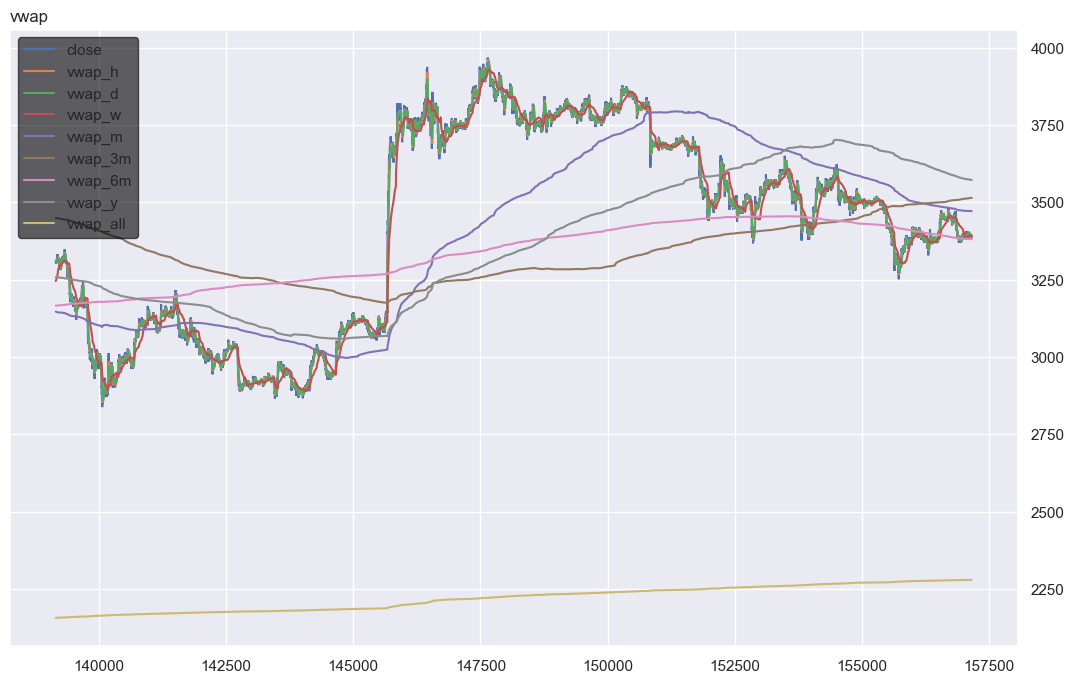

In [44]:
nb_point = 18000
fig = plt.figure()
fig.set_size_inches([13,8])
plt.plot(df_eth[-nb_point:].Close, label="close")
plt.plot(df_eth[-nb_point:]["vwap_h"], label='vwap_h')
plt.plot(df_eth[-nb_point:]["vwap_d"], label='vwap_d')
plt.plot(df_eth[-nb_point:]["vwap_w"], label='vwap_w')
plt.plot(df_eth[-nb_point:]["vwap_m"], label='vwap_m')
plt.plot(df_eth[-nb_point:]["vwap_3m"], label='vwap_3m')
plt.plot(df_eth[-nb_point:]["vwap_6m"], label='vwap_6m')
plt.plot(df_eth[-nb_point:]["vwap_y"], label='vwap_y')
plt.plot(df_eth[-nb_point:]["vwap_all"], label='vwap_all')
plt.title('vwap')
plt.legend()
plt.show()

- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [45]:
# MVRV Z-score : (Market Value - Realized Value) / Std(Market Value)
# approximated by : (Close - VWAP(all time) ) / Std(Close from first date)
# nb_max_period = df_eth.shape[0]

df_eth["vwap_z_score"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"].expanding(1).std()
df_btc["vwap_z_score"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"].expanding(1).std()
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,49.041038,3389.438395,3388.456986,3393.164211,3471.854215,3514.715949,3380.893042,3572.893985,2279.405025,1.542140
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,49.037469,3390.007587,3388.499120,3393.146869,3471.842182,3514.723763,3380.883429,3572.871474,2279.406385,1.541480
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,49.033862,3390.442564,3388.355316,3393.139641,3471.833316,3514.753495,3380.877141,3572.809098,2279.407398,1.540171
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,49.030183,3390.528933,3388.326147,3393.134969,3471.808979,3514.758865,3380.872307,3572.790182,2279.408521,1.533746


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on all times



In [46]:
# NUPL 
df_eth["nupl"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"]
df_btc["nupl"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"]
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,3389.438395,3388.456986,3393.164211,3471.854215,3514.715949,3380.893042,3572.893985,2279.405025,1.542140,0.328524
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,3390.007587,3388.499120,3393.146869,3471.842182,3514.723763,3380.883429,3572.871474,2279.406385,1.541480,0.328431
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,3390.442564,3388.355316,3393.139641,3471.833316,3514.753495,3380.877141,3572.809098,2279.407398,1.540171,0.328245
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,3390.528933,3388.326147,3393.134969,3471.808979,3514.758865,3380.872307,3572.790182,2279.408521,1.533746,0.327324


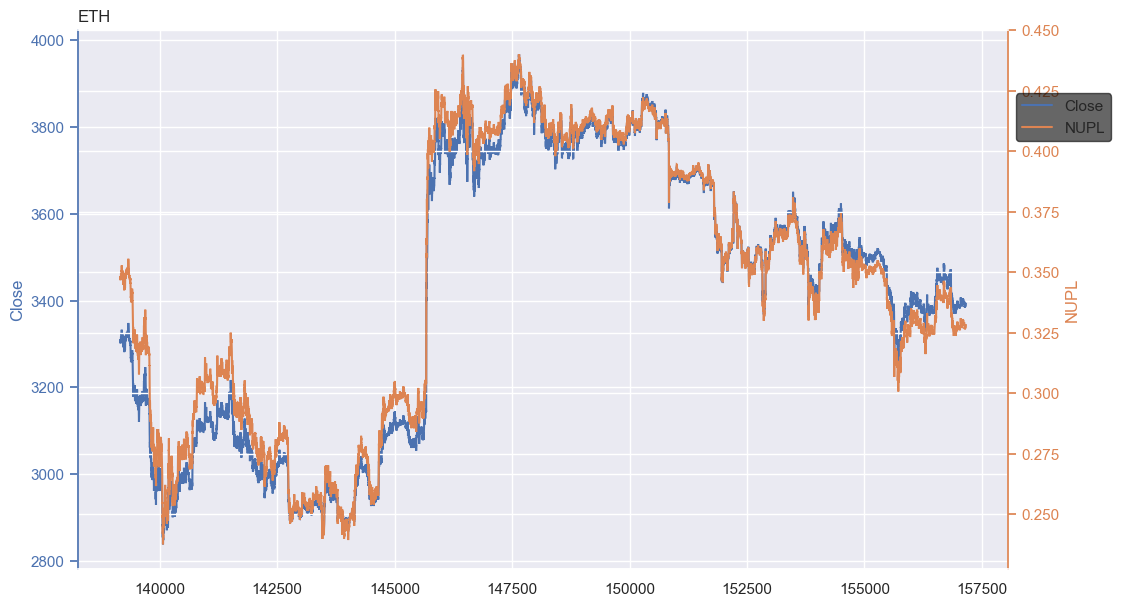

In [47]:
nb_point = 18000



fig, ax1 = plt.subplots()
fig.set_size_inches([12,7])
ax1.plot(df_eth[-nb_point:].Close)
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title('ETH')

ax2 = ax1.twinx()
ax2.plot(df_eth[-nb_point:]["nupl"],'C1')
ax2.set_ylabel('NUPL', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(['Close','NUPL'], bbox_to_anchor=(0.9, 0.8))

plt.show()

## Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [48]:
# https://api.alternative.me/fng/?limit=370&format=csv
nb_days = int(np.ceil(df_eth.shape[0]/24))
response = requests.get(f"https://api.alternative.me/fng/?limit={nb_days}")

d_fear = json.loads(response.text)
nb_days = len(d_fear["data"])
df_fear = pd.DataFrame(
    [int(d_fear["data"][i_time]["timestamp"])*1000 
     for i_time in range(nb_days) ], columns=["Time"])
df_fear["fear_greed"] = [
    int(d_fear["data"][i_time]["value"]) 
    for i_time in range(nb_days)]
df_fear["fear_greed_class"] = [
    d_fear["data"][i_time]["value_classification"]
    for i_time in range(nb_days)]

df_eth = df_eth.merge(df_fear, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_eth["fear_greed"] = df_eth["fear_greed"].ffill()
df_eth["fear_greed_class"] = df_eth["fear_greed_class"].ffill()
df_eth.loc[df_eth["fear_greed"].isna(), "fear_greed"] = 50
df_eth.loc[df_eth["fear_greed_class"].isna(), "fear_greed_class"] = "Neutral"
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,3393.164211,3471.854215,3514.715949,3380.893042,3572.893985,2279.405025,1.542140,0.328524,30.0,Fear
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,3393.146869,3471.842182,3514.723763,3380.883429,3572.871474,2279.406385,1.541480,0.328431,30.0,Fear
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,3393.139641,3471.833316,3514.753495,3380.877141,3572.809098,2279.407398,1.540171,0.328245,30.0,Fear
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,3393.134969,3471.808979,3514.758865,3380.872307,3572.790182,2279.408521,1.533746,0.327324,30.0,Fear


In [49]:
df_eth.head(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear
5,1672532700000,1196.06,1196.70,1196.06,1196.61,394.9124,2023-01-01 00:25:00,2238.718373,2237.876339,NaN,...,1195.754893,1195.754893,1195.754893,1195.754893,1195.754893,1195.754893,1.150158,0.000715,26.0,Fear
6,1672533000000,1196.62,1196.62,1193.72,1194.36,497.8406,2023-01-01 00:30:00,2238.718373,2237.876339,NaN,...,1195.607388,1195.607388,1195.607388,1195.607388,1195.607388,1195.607388,-1.427337,-0.001044,26.0,Fear
7,1672533300000,1194.37,1194.43,1192.72,1194.22,1299.5971,2023-01-01 00:35:00,2238.718373,2237.876339,NaN,...,1195.043013,1195.043013,1195.043013,1195.043013,1195.043013,1195.043013,-0.869632,-0.000689,26.0,Fear
8,1672533600000,1194.22,1194.22,1193.02,1193.64,409.5032,2023-01-01 00:40:00,2238.718373,2237.876339,NaN,...,1194.916773,1194.916773,1194.916773,1194.916773,1194.916773,1194.916773,-1.194916,-0.001070,26.0,Fear
9,1672533900000,1193.64,1195.06,1193.63,1194.64,521.0221,2023-01-01 00:45:00,2238.718373,2237.876339,NaN,...,1194.868552,1194.868552,1194.868552,1194.868552,1194.868552,1194.868552,-0.223011,-0.000191,26.0,Fear


In [50]:
df_eth.tail(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
157131,1719670500000,3391.67,3392.35,3387.81,3388.53,385.8099,2024-06-29 14:15:00,3401.0750,3396.625,3395.190,...,3393.433555,3472.059225,3514.516383,3381.112656,3573.278648,2279.372422,1.533912,0.327327,30.0,Fear
157132,1719670800000,3388.52,3388.52,3384.19,3385.64,695.3206,2024-06-29 14:20:00,3400.9225,3396.625,3392.360,...,3393.413057,3472.042498,3514.518391,3381.096843,3573.250944,2279.376070,1.529903,0.326752,30.0,Fear
157133,1719671100000,3385.65,3387.07,3383.00,3385.73,933.1205,2024-06-29 14:25:00,3400.9225,3396.625,3391.765,...,3393.325930,3472.017648,3514.527859,3381.086469,3573.222619,2279.380962,1.530013,0.326768,30.0,Fear
157134,1719671400000,3385.74,3388.77,3385.01,3385.62,489.6390,2024-06-29 14:30:00,3400.8700,3396.625,3391.765,...,3393.292161,3472.003607,3514.529279,3381.072951,3573.185669,2279.383532,1.529850,0.326746,30.0,Fear
157135,1719671700000,3385.63,3387.34,3384.33,3386.39,310.7385,2024-06-29 14:35:00,3400.8700,3396.625,3391.765,...,3393.305939,3471.984431,3514.532735,3381.062938,3573.167171,2279.385162,1.530906,0.326898,30.0,Fear
157136,1719672000000,3386.40,3386.40,3383.80,3385.22,161.3799,2024-06-29 14:40:00,3400.4500,3396.625,3391.765,...,3393.296890,3471.976541,3514.545288,3381.054198,3573.154023,2279.386008,1.529279,0.326665,30.0,Fear
157137,1719672300000,3385.22,3386.80,3384.14,3385.91,252.3473,2024-06-29 14:45:00,3400.1750,3396.625,3391.765,...,3393.360082,3471.968965,3514.555090,3381.043393,3573.140674,2279.387332,1.530224,0.326802,30.0,Fear
157138,1719672600000,3385.90,3388.00,3385.19,3388.00,234.8344,2024-06-29 14:50:00,3399.8000,3396.625,3391.765,...,3393.383265,3471.962778,3514.577470,3381.034456,3573.122781,2279.388565,1.533105,0.327217,30.0,Fear
157139,1719672900000,3388.00,3388.67,3387.50,3388.00,384.0719,2024-06-29 14:55:00,3398.0175,3396.625,3391.765,...,3393.390211,3471.951914,3514.594267,3381.022541,3573.109276,2279.390583,1.533095,0.327216,30.0,Fear
157140,1719673200000,3388.00,3389.66,3387.19,3389.02,190.4471,2024-06-29 15:00:00,3397.1550,3396.625,3391.765,...,3393.396763,3471.943129,3514.607169,3381.010131,3573.084894,2279.391585,1.534497,0.327419,30.0,Fear


## Daily economic infos 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago : NOK
- STH-MVRV ? equiv to Price / VWAP of the last 6 months : NOK
- Dave’s Logarithmic Growth Curve ? : NOK

Others tickers:

- US02Y no but US05Y from yahoo finance
- ETHBTC : to be calculated
- SP500
- DXY

TODO ? 
- open interest 
- NASDAC


US02Y : 

In [51]:
datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2023, 1, 1, 0, 0)

openbb  for index is not good about datetime and DXY no data

In [52]:
openbb.economy.available_indices()

{'sp500': {'name': 'S&P 500 Index', 'ticker': '^GSPC'},
 'sp400': {'name': 'S&P 400 Mid Cap Index', 'ticker': '^SP400'},
 'sp600': {'name': 'S&P 600 Small Cap Index', 'ticker': '^SP600'},
 'sp500tr': {'name': 'S&P 500 TR Index', 'ticker': '^SP500TR'},
 'sp_xsp': {'name': 'S&P 500 Mini SPX Options Index', 'ticker': '^XSP'},
 'nyse_ny': {'name': 'NYSE US 100 Index', 'ticker': '^NY'},
 'dow_djus': {'name': 'Dow Jones US Index', 'ticker': '^DJUS'},
 'nyse': {'name': 'NYSE Composite Index', 'ticker': '^NYA'},
 'amex': {'name': 'NYSE-AMEX Composite Index', 'ticker': '^XAX'},
 'nasdaq': {'name': 'Nasdaq Composite Index', 'ticker': '^IXIC'},
 'nasdaq100': {'name': 'NASDAQ 100', 'ticker': '^NDX'},
 'nasdaq100_ew': {'name': 'NASDAQ 100 Equal Weighted Index',
  'ticker': '^NDXE'},
 'nasdaq50': {'name': 'NASDAQ Q50 Index', 'ticker': '^NXTQ'},
 'russell1000': {'name': 'Russell 1000 Index', 'ticker': '^RUI'},
 'russell2000': {'name': 'Russell 2000 Index', 'ticker': '^RUT'},
 'cboe_bxr': {'name': 'CB

In [53]:
# openbb.economy.treasury(maturity=["2y"], start_date="2023-01-01")

In [54]:
def req_yf_date(ticker):
    data = yf.Ticker(ticker).history(interval="1h", period="2y")
    # date
    data["date"] = pd.to_datetime(data.index, utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    data["Time"] = data["date"].apply(exchange.parse8601)
    data["date"] = pd.to_datetime(data["date"],  utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    data = data.reset_index()
    print("First date: ", data["Datetime"].values[0])
    print("Last date: ", data["Datetime"].values[-1])
    # data = data[["Time", "date", "Close"]]
    return data

def add_ticker_data(symbol, path_data):
    """
    Merge new data
    not optimized : download all new data and merge
    """
    df_new = req_yf_date(symbol)
    if os.path.isfile(path_data):
        df = pd.read_csv(path_data)
        list_col = df.columns
        if df["Time"].values[-1] < df_new["Time"].values[-1]:
            print("New data available...")
            df = df.merge(df_new, 
                left_on='Time', 
                right_on='Time', 
                how="outer",
                suffixes=("", "_new")
            )
            for col in list_col:
                if col != 'Time':
                    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), f"{col}_new"]

            df = df[list_col]
            df.to_csv(path_data, index=False)

        return df
    else:
        df_new.to_csv(path_data, index=False)
        return df_new

U.S. Treasury Yield 5 Years

In [55]:
#df_fvx = yf.Ticker("^FVX").history(interval="1h", period="2y")
path_fvx = os.path.join(PATH_DATA, "df_fvx.csv")
df_fvx = add_ticker_data("^FVX", path_fvx)
df_fvx

First date:  2022-06-29T12:20:00.000000000
Last date:  2024-06-28T18:20:00.000000000
New data available...


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 08:00:00-05:00,0.514,0.524,0.514,0.521,0.0,0.0,0.0,2021-02-16 13:00:00,1613480400000
1,2021-02-16 09:00:00-05:00,0.521,0.527,0.516,0.527,0.0,0.0,0.0,2021-02-16 14:00:00,1613484000000
2,2021-02-16 10:00:00-05:00,0.529,0.532,0.522,0.529,0.0,0.0,0.0,2021-02-16 15:00:00,1613487600000
3,2021-02-16 11:00:00-05:00,0.529,0.553,0.529,0.551,0.0,0.0,0.0,2021-02-16 16:00:00,1613491200000
4,2021-02-16 12:00:00-05:00,0.551,0.553,0.545,0.546,0.0,0.0,0.0,2021-02-16 17:00:00,1613494800000
...,...,...,...,...,...,...,...,...,...,...
9411,2024-06-28 09:20:00-05:00,4.259,4.334,4.259,4.324,0.0,0.0,0.0,2024-06-28 14:20:00,1719584400000
9412,2024-06-28 10:20:00-05:00,4.318,4.334,4.313,4.333,0.0,0.0,0.0,2024-06-28 15:20:00,1719588000000
9413,2024-06-28 11:20:00-05:00,4.331,4.348,4.325,4.333,0.0,0.0,0.0,2024-06-28 16:20:00,1719591600000
9414,2024-06-28 12:20:00-05:00,4.343,4.343,4.327,4.327,0.0,0.0,0.0,2024-06-28 17:20:00,1719595200000


SPX

In [56]:
# S&P 500 = "^GSPC"
# df_spx = yf.Ticker("^GSPC").history(interval="1h", period="2y")
path_sp500 = os.path.join(PATH_DATA, "df_sp500.csv")
df_sp500 = add_ticker_data("^GSPC", path_sp500)
df_sp500

First date:  2022-06-29T13:30:00.000000000
Last date:  2024-06-28T19:30:00.000000000
New data available...


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
5916,2024-06-28 11:30:00-04:00,5498.109863,5503.370117,5483.049805,5490.229980,250252839.0,0.0,0.0,2024-06-28 15:30:00,1719588600000
5917,2024-06-28 12:30:00-04:00,5490.229980,5491.529785,5476.200195,5483.529785,227458000.0,0.0,0.0,2024-06-28 16:30:00,1719592200000
5918,2024-06-28 13:30:00-04:00,5483.500000,5486.180176,5473.490234,5474.620117,207090000.0,0.0,0.0,2024-06-28 17:30:00,1719595800000
5919,2024-06-28 14:30:00-04:00,5474.589844,5476.859863,5466.870117,5468.390137,243875000.0,0.0,0.0,2024-06-28 18:30:00,1719599400000


DXY

In [57]:
#df_dxy = yf.Ticker("DX-Y.NYB").history(interval="1h", period="2y")
path_dxy = os.path.join(PATH_DATA, "df_dxy.csv")
df_dxy = add_ticker_data("DX-Y.NYB", path_dxy)   
df_dxy

First date:  2022-06-29T04:00:00.000000000
Last date:  2024-06-28T20:00:00.000000000
New data available...


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 00:00:00-05:00,90.290001,90.334000,90.280998,90.305000,0.0,0.0,0.0,2021-02-16 05:00:00,1613451600000
1,2021-02-16 01:00:00-05:00,90.306000,90.329002,90.292999,90.294998,0.0,0.0,0.0,2021-02-16 06:00:00,1613455200000
2,2021-02-16 02:00:00-05:00,90.294998,90.375000,90.277000,90.362999,0.0,0.0,0.0,2021-02-16 07:00:00,1613458800000
3,2021-02-16 03:00:00-05:00,90.362000,90.369003,90.205002,90.218002,0.0,0.0,0.0,2021-02-16 08:00:00,1613462400000
4,2021-02-16 04:00:00-05:00,90.218002,90.269997,90.202003,90.220001,0.0,0.0,0.0,2021-02-16 09:00:00,1613466000000
...,...,...,...,...,...,...,...,...,...,...
20632,2024-06-28 12:00:00-04:00,105.879997,105.889000,105.796997,105.833000,0.0,0.0,0.0,2024-06-28 16:00:00,1719590400000
20633,2024-06-28 13:00:00-04:00,105.834000,105.844002,105.745003,105.838997,0.0,0.0,0.0,2024-06-28 17:00:00,1719594000000
20634,2024-06-28 14:00:00-04:00,105.838997,105.871002,105.804001,105.865997,0.0,0.0,0.0,2024-06-28 18:00:00,1719597600000
20635,2024-06-28 15:00:00-04:00,105.865997,105.917999,105.860001,105.871002,0.0,0.0,0.0,2024-06-28 19:00:00,1719601200000


In [58]:
df_sp500

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
5916,2024-06-28 11:30:00-04:00,5498.109863,5503.370117,5483.049805,5490.229980,250252839.0,0.0,0.0,2024-06-28 15:30:00,1719588600000
5917,2024-06-28 12:30:00-04:00,5490.229980,5491.529785,5476.200195,5483.529785,227458000.0,0.0,0.0,2024-06-28 16:30:00,1719592200000
5918,2024-06-28 13:30:00-04:00,5483.500000,5486.180176,5473.490234,5474.620117,207090000.0,0.0,0.0,2024-06-28 17:30:00,1719595800000
5919,2024-06-28 14:30:00-04:00,5474.589844,5476.859863,5466.870117,5468.390137,243875000.0,0.0,0.0,2024-06-28 18:30:00,1719599400000


merge with df_eth

In [59]:
df_eth[df_eth["date"] == "2023-02-16 16:00:00"]

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
13440,1676563200000,1724.14,1742.97,1723.15,1740.25,15652.277,2023-02-16 16:00:00,1682.43,1682.43,1704.105,...,1691.967459,1600.472878,1529.969567,1529.969567,1597.951882,1529.969567,1.4078,0.120833,62.0,Greed


In [60]:
df_sp500[df_sp500["date"] == "2023-02-16 16:00:00"]

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time


In [61]:

df_yf_in = df_sp500[["Time", "Close"]].copy()
df_yf_in.rename(columns={"Close": "spx"}, inplace=True)
df_yf_in

,Time,spx
0,1613485800000,3948.080078
1,1613489400000,3934.110107
2,1613493000000,3936.729980
3,1613496600000,3937.399902
4,1613500200000,3939.929932
...,...,...
5916,1719588600000,5490.229980
5917,1719592200000,5483.529785
5918,1719595800000,5474.620117
5919,1719599400000,5468.390137


In [62]:
pd.to_datetime(df_fvx["date"].iloc[0]).minute != 0

False

In [63]:
print(df_sp500["date"].iloc[0])
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
if nb_minutes != 0:
    print(df_sp500["Time"].iloc[0])
    timestamp_new = df_sp500["Time"].iloc[0] + (60 - nb_minutes) * 60 * 1000
    print(datetime.fromtimestamp(timestamp_new/1000, tz=timezone.utc))


2021-02-16 14:30:00
1613485800000
2021-02-16 15:00:00+00:00


In [64]:
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
df_spx = df_sp500.copy()
df_spx["Time"] = df_spx["Time"] + (60 - nb_minutes) * 60 * 1000


In [65]:
df_test = df_eth.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_test["spx"].notna().value_counts()

False    154545
True       2611
Name: spx, dtype: int64

In [66]:
# merge with df_eth
def merge_daily_yf(df, df_yf, name):
    df_in = df.copy()
    df_yf_in = df_yf.copy()
    # check if minutes
    nb_minutes = pd.to_datetime(df_yf_in["date"].iloc[0]).minute
    if nb_minutes != 0:
        df_yf_in["Time"] = df_yf_in["Time"] + (60 - nb_minutes) * 60 * 1000
    

    df_yf_in = df_yf_in[["Time", "Close"]]
    df_yf_in.rename(columns={"Close": name}, inplace=True)
    df_in = df_in.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    df_in[name] = df_in[name].ffill()
    
    return df_in

df_eth_merge = merge_daily_yf(df_eth, df_fvx, "fvx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_sp500, "spx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_dxy, "dxy")

df_eth_merge

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,3380.893042,3572.893985,2279.405025,1.542140,0.328524,30.0,Fear,4.329,5460.47998,105.848999
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,3380.883429,3572.871474,2279.406385,1.541480,0.328431,30.0,Fear,4.329,5460.47998,105.848999
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,3380.877141,3572.809098,2279.407398,1.540171,0.328245,30.0,Fear,4.329,5460.47998,105.848999
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,3380.872307,3572.790182,2279.408521,1.533746,0.327324,30.0,Fear,4.329,5460.47998,105.848999


In [67]:
df_eth = df_eth_merge.copy()

## Economy calendar

In [68]:
help(openbb.economy.events)

Help on get_economic_calendar in module openbb_terminal.economy.nasdaq_model object:

class get_economic_calendar(builtins.object)
 |  get_economic_calendar(countries: Union[List[str], str] = '', start_date: Optional[str] = None, end_date: Optional[str] = None) -> pandas.core.frame.DataFrame
 |  
 |  Get economic calendar for countries between specified dates
 |  
 |  Parameters
 |  ----------
 |  countries : [List[str],str]
 |      List of countries to include in calendar.  Empty returns all
 |  start_date : Optional[str]
 |      Start date for calendar
 |  end_date : Optional[str]
 |      End date for calendar
 |  
 |  Returns
 |  -------
 |  pd.DataFrame
 |      Economic calendar
 |  
 |  Examples
 |  --------
 |  Get todays economic calendar for the United States
 |  >>> from openbb_terminal.sdk import openbb
 |  >>> calendar = openbb.economy.events("united_states")
 |  
 |  To get multiple countries for a given date, pass the same start and end date as well as
 |  a list of countr

In [69]:
os.path.isfile(path_save_df_eco)

True

In [70]:
# Time : timestamp unix UTC
# date : string UTC
def reduce_date_str(str_date):
    date_obj = datetime.strptime(str_date, "%Y-%m-%d %H:%M:%S")
    return date_obj.strftime("%Y-%m-%d")

def add_days(str_date_0, nb_days_CV, date_format="%Y-%m-%d"):
    '''
    add days to string dates
    '''
    date_last = datetime.strptime(str_date_0, date_format)
    date_start = date_last + timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def update_eco_data(df_eco):
    """
    Update with new data.
    Add one day after last date LAST_DATE
    and update Actual data
    """
    # Find last Actual data to find the last update time 
    last_actual_data = df_eco[df_eco["Actual"] != '-']["Date"].iloc[-1]
    print("start date to download: ", last_actual_data)
    # Take it as First date to download data
    last_new_date_eco = reduce_date_str(add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    print("end date to download: ",  last_new_date_eco)
    # Download data
    df_eco_new = openbb.economy.events(
        start_date=last_actual_data, 
        end_date=last_new_date_eco,
        countries = ['United States'],
    )
    print("df_eco_new.shape: ", df_eco_new.shape)
    # Merge new data and update Actual info
    df_eco_last = pd.concat([df_eco, df_eco_new], ignore_index=True)
    print("df_eco.shape: ", df_eco.shape)
    print("Before : df_eco_last.shape: ", df_eco_last.shape)
    df_eco_last = df_eco_last.drop_duplicates(
        subset=["Event", "Date", "Time (ET)"], keep="last")
    print("After : df_eco_last.shape: ", df_eco_last.shape)

    return df_eco_last

In [71]:
if os.path.isfile(path_save_df_eco):
    df_eco = pd.read_csv(path_save_df_eco)
    df_eco = update_eco_data(df_eco)
    df_eco.to_csv(path_save_df_eco, index=False)
    
else:
    last_new_date_eco = reduce_date_str(
        add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    df_eco = openbb.economy.events(start_date="2021-01-01",
                                   end_date=last_new_date_eco,
                                   countries = ['United States'])
    df_eco.to_csv(path_save_df_eco,index=False)
    
df_eco

start date to download:  2024-06-13
end date to download:  2024-06-30
df_eco_new.shape:  (239, 7)
df_eco.shape:  (15579, 7)
Before : df_eco_last.shape:  (15818, 7)
After : df_eco_last.shape:  (15767, 7)


,Time (ET),Country,Event,Actual,Consensus,Previous,Date
0,All Day,United States,United States - New Year's Day,-,-,-,2021-01-01
1,09:45,United States,Manufacturing PMI,57.1,-,56.5,2021-01-04
2,10:00,United States,Chicago Fed President Evans Speaks,-,-,-,2021-01-04
3,10:00,United States,Construction Spending,0.9%,1.0%,1.6%,2021-01-04
4,10:00,United States,FOMC Member Bostic Speaks,-,-,-,2021-01-04
...,...,...,...,...,...,...,...
15813,16:30,United States,Fed Bank Stress Test Results,-,,-,2024-06-28
15814,16:30,United States,Fed's Balance Sheet,"7,231B",,"7,253B",2024-06-28
15815,16:30,United States,Reserve Balances with Federal Reserve Banks,3.269T,,3.366T,2024-06-28
15816,21:00,United States,U.S. President Biden Speaks,-,,-,2024-06-28


Filter events
- Core CPI
- PPI
- Fed Interest Rate Decision
- Bank Holidays

In [72]:
# Core CPI : The core consumer price inflation rate in the United States
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="Core CPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
133,08:30,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13
491,08:30,United States,Core CPI,1.4%,1.5%,1.6%,2021-02-10
858,08:30,United States,Core CPI,0.1%,0.2%,0.1%,2021-03-10
1276,07:30,United States,Core CPI,1.6%,1.5%,1.3%,2021-04-13
1649,07:30,United States,Core CPI,0.9%,0.3%,0.3%,2021-05-12
2020,07:30,United States,Core CPI,3.8%,3.4%,3.0%,2021-06-10
2379,07:30,United States,Core CPI,4.5%,4.0%,3.8%,2021-07-13
2730,07:30,United States,Core CPI,4.3%,4.3%,4.5%,2021-08-11
3115,07:30,United States,Core CPI,0.1%,0.3%,0.3%,2021-09-14
3474,07:30,United States,Core CPI,4.0%,4.0%,4.0%,2021-10-13


In [73]:
# PPI : United States Producer Price Inflation 
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="PPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
174,08:30,United States,PPI,0.8%,0.8%,0.8%,2021-01-15
566,08:30,United States,PPI,1.3%,0.4%,0.3%,2021-02-17
889,08:30,United States,PPI,2.8%,2.7%,1.7%,2021-03-12
1247,07:30,United States,PPI,4.2%,3.8%,2.8%,2021-04-09
1678,07:30,United States,PPI,0.6%,0.3%,1.0%,2021-05-13
2062,07:30,United States,PPI,0.8%,0.6%,0.6%,2021-06-15
2401,07:30,United States,PPI,1.0%,0.6%,0.8%,2021-07-14
2759,07:30,United States,PPI,7.8%,7.3%,7.3%,2021-08-12
3090,07:30,United States,PPI,0.7%,0.6%,1.0%,2021-09-10
3494,07:30,United States,PPI,0.5%,0.6%,0.7%,2021-10-14


In [74]:
# Fed interesst rate
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] == "Fed Interest Rate Decision"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27
958,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-03-17
1464,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-04-28
2107,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-06-16
2563,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-07-28
3222,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-09-22
3766,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-11-03
4291,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-12-15
4751,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2022-01-26
5371,13:00,United States,Fed Interest Rate Decision,0.50%,0.50%,0.25%,2022-03-16


In [75]:
# sentiment = -1 by default
df_eco[df_eco["Event"].str.contains("FOMC Meeting Minutes")]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
58,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-01-06
580,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-02-17
1236,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-04-07
1752,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-05-19
2331,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-07-07
2827,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-08-18
3484,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-10-13
4047,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-11-24
4510,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-01-05
5023,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-02-16


In [76]:
df_eco[df_eco["Event"] == "Core CPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
133,08:30,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13
491,08:30,United States,Core CPI,1.4%,1.5%,1.6%,2021-02-10
858,08:30,United States,Core CPI,0.1%,0.2%,0.1%,2021-03-10
1276,07:30,United States,Core CPI,1.6%,1.5%,1.3%,2021-04-13
1649,07:30,United States,Core CPI,0.9%,0.3%,0.3%,2021-05-12
2020,07:30,United States,Core CPI,3.8%,3.4%,3.0%,2021-06-10
2379,07:30,United States,Core CPI,4.5%,4.0%,3.8%,2021-07-13
2730,07:30,United States,Core CPI,4.3%,4.3%,4.5%,2021-08-11
3115,07:30,United States,Core CPI,0.1%,0.3%,0.3%,2021-09-14
3474,07:30,United States,Core CPI,4.0%,4.0%,4.0%,2021-10-13


In [77]:
df_eco[df_eco["Time (ET)"] == "All Day"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
0,All Day,United States,United States - New Year's Day,-,-,-,2021-01-01
203,All Day,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2021-01-18
547,All Day,United States,United States - Presidents' Day,-,-,-,2021-02-15
1188,All Day,United States,United States - Good Friday,-,-,-,2021-04-02
1891,All Day,United States,United States - Memorial Day,-,-,-,2021-05-31
2311,All Day,United States,United States - Independence Day,-,-,-,2021-07-05
3048,All Day,United States,United States - Labor Day,-,-,-,2021-09-06
4048,All Day,United States,United States - Thanksgiving Day,-,-,-,2021-11-25
4049,All Day,United States,United States - Thanksgiving Day - Early close...,-,-,-,2021-11-26
4394,All Day,United States,United States - Christmas,-,-,-,2021-12-24


In [78]:
list_filter_eco = ["Fed Interest Rate Decision", "Core CPI", "PPI"]
for value in list_filter_eco:
    print(f'{value} : {df_eco[df_eco["Event"] == value].shape[0]}')
    print(df_eco[df_eco["Event"] == value]["Event"])

def apply_eco_filter(str_event):
    if str_event in list_filter_eco:
        return 1
    else:
        return 0

df_eco_filter = df_eco.copy()
# keep only events in list
df_eco_filter["keep"] = df_eco_filter["Event"].apply(apply_eco_filter)
# also keep bank holidays
df_eco_filter.loc[df_eco_filter["Time (ET)"] == "All Day" ,"keep"]  = 1
df_eco_filter = df_eco_filter.loc[df_eco_filter["keep"] == 1]


def apply_ppc_to_num(str_ppc):
    str_ppc = str_ppc.strip()
    if (str_ppc == "") or (str_ppc == "-"):
        return 0
    return float(str_ppc[:-1])

def apply_norm_event(delta_value):
    if delta_value > 0:
        return +1
    elif delta_value == 0:
        return 0
    else:
        return -1

# ppc to num
df_eco_filter["Actual_num"] = df_eco_filter["Actual"].apply(apply_ppc_to_num)
df_eco_filter["Consensus_num"] = df_eco_filter["Consensus"].apply(apply_ppc_to_num)
df_eco_filter["Previous_num"] = df_eco_filter["Previous"].apply(apply_ppc_to_num)
# delta 
# event_pred : if Previous > Consensus: +1, else -1
df_eco_filter["delta_event_pred"] = df_eco_filter["Previous_num"] - df_eco_filter["Consensus_num"]
df_eco_filter["event_pred"] = df_eco_filter["delta_event_pred"].apply(apply_norm_event)
# event_real : if Consensus > Actual: +1, else -1 
df_eco_filter["delta_event_real"] = df_eco_filter["Consensus_num"] - df_eco_filter["Actual_num"]
df_eco_filter["event_real"] = df_eco_filter["delta_event_real"].apply(apply_norm_event)

df_eco_filter.tail(20)

Fed Interest Rate Decision : 28
307      Fed Interest Rate Decision
958      Fed Interest Rate Decision
1464     Fed Interest Rate Decision
2107     Fed Interest Rate Decision
2563     Fed Interest Rate Decision
3222     Fed Interest Rate Decision
3766     Fed Interest Rate Decision
4291     Fed Interest Rate Decision
4751     Fed Interest Rate Decision
5371     Fed Interest Rate Decision
5974     Fed Interest Rate Decision
6481     Fed Interest Rate Decision
6923     Fed Interest Rate Decision
7576     Fed Interest Rate Decision
8112     Fed Interest Rate Decision
8611     Fed Interest Rate Decision
9136     Fed Interest Rate Decision
9773     Fed Interest Rate Decision
10297    Fed Interest Rate Decision
10812    Fed Interest Rate Decision
11988    Fed Interest Rate Decision
12588    Fed Interest Rate Decision
12614    Fed Interest Rate Decision
13189    Fed Interest Rate Decision
13779    Fed Interest Rate Decision
14440    Fed Interest Rate Decision
15002    Fed Interest Rate Decis

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real
13538,08:30,United States,PPI,1.0%,1.3%,0.8%,2024-01-12,1,1.0,1.3,0.8,-0.5,-1,0.3,1
13555,All Day,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2024-01-15,1,0.0,0.0,0.0,0.0,0,0.0,0
13779,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-01-31,1,5.5,5.5,5.5,0.0,0,0.0,0
13924,08:30,United States,Core CPI,3.9%,3.7%,3.9%,2024-02-13,1,3.9,3.7,3.9,0.2,1,-0.2,-1
13993,08:30,United States,PPI,0.3%,0.1%,-0.1%,2024-02-16,1,0.3,0.1,-0.1,-0.2,-1,-0.2,-1
14015,All Day,United States,United States - Washington's Birthday,-,-,-,2024-02-19,1,0.0,0.0,0.0,0.0,0,0.0,0
14332,08:30,United States,Core CPI,3.8%,3.7%,3.9%,2024-03-12,1,3.8,3.7,3.9,0.2,1,-0.1,-1
14369,08:30,United States,PPI,0.6%,0.3%,0.3%,2024-03-14,1,0.6,0.3,0.3,0.0,0,-0.3,-1
14440,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-03-20,1,5.5,5.5,5.5,0.0,0,0.0,0
14588,All Day,United States,United States - Good Friday,-,-,-,2024-03-29,1,0.0,0.0,0.0,0.0,0,0.0,0


Clean eco data

In [79]:
def get_round_time(time_str):
    """
    Get  round time : 
        example : 
        print(get_round_time('07:20'))
        07:00
        print(get_round_time('07:30'))
        07:00
        print(get_round_time('07:31'))
        08:00
        print(get_round_time('11:31'))
        12:00
    TODO : if time is 23:31 ? output is not good  ! 24:00 (but not into this data)
            => need to add + 1 day
    """
    if time_str == "All Day":
        return "00:00"
    str_minutes = time_str[-2:]
    str_hours = time_str[-5:-3]
    if int(str_minutes)  <= 30 : 
        return str_hours + ":00" 
    else:
        str_time = f"{int(str_hours)+1}:00"
        if len(str_time) < 5:
            str_time = "0" + str_time
        return str_time

def clean_eco_data(df_eco):
    """
    Clean agenda : remove Tentative, add day_off for All Day,
    round minutes 
    """
    df_eco_clean = df_eco.copy()
    df_eco_clean = df_eco_clean[df_eco_clean["Time (ET)"] != "Tentative"]
    df_eco_clean["day_off"] = 0
    df_eco_clean.loc[df_eco_clean["Time (ET)"] == "All Day","day_off"] = 1
    df_eco_clean.loc[
        df_eco_clean["Time (ET)"] == "All Day", "Time (ET)"] = "00:00"
    print(df_eco_clean["Time (ET)"].unique())
    df_eco_clean["Time (ET)"] = df_eco_clean["Time (ET)"].apply(get_round_time)
    print(df_eco_clean["Time (ET)"].unique())

    return df_eco_clean

def add_time_eco(df_eco):
    df = df_eco.copy() 
    # add timezone ET info
    df["date"] = df["Date"] + " " + df["Time (ET)"] + ":00-05:00"
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df

df_eco_clean = clean_eco_data(df_eco_filter)

df_eco_final = add_time_eco(df_eco_clean)

df_eco_final.tail(10)

['00:00' '08:30' '14:00' '13:00' '07:30' '09:30']
['00:00' '08:00' '14:00' '13:00' '07:00' '09:00']


,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
14704,08:00,United States,Core CPI,0.4%,0.3%,0.4%,2024-04-10,1,0.4,0.3,0.4,0.1,1,-0.1,-1,0,2024-04-10 13:00:00,1712754000000
14738,08:00,United States,PPI,2.1%,2.2%,1.6%,2024-04-11,1,2.1,2.2,1.6,-0.6,-1,0.1,1,0,2024-04-11 13:00:00,1712840400000
15002,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-05-01,1,5.5,5.5,5.5,0.0,0,0.0,0,0,2024-05-01 19:00:00,1714590000000
15138,08:00,United States,PPI,0.5%,0.3%,-0.1%,2024-05-14,1,0.5,0.3,-0.1,-0.4,-1,-0.2,-1,0,2024-05-14 13:00:00,1715691600000
15150,08:00,United States,Core CPI,3.6%,3.6%,3.8%,2024-05-15,1,3.6,3.6,3.8,0.2,1,0.0,0,0,2024-05-15 13:00:00,1715778000000
15309,00:00,United States,United States - Memorial Day,,,,2024-05-27,1,0.0,0.0,0.0,0.0,0,0.0,0,1,2024-05-27 05:00:00,1716786000000
15513,08:00,United States,Core CPI,3.4%,3.5%,3.6%,2024-06-12,1,3.4,3.5,3.6,0.1,1,0.1,1,0,2024-06-12 13:00:00,1718197200000
15540,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-06-12,1,5.5,5.5,5.5,0.0,0,0.0,0,0,2024-06-12 19:00:00,1718218800000
15587,08:00,United States,PPI,2.2%,2.5%,2.3%,2024-06-13,1,2.2,2.5,2.3,-0.2,-1,0.3,1,0,2024-06-13 13:00:00,1718283600000
15656,00:00,United States,United States - Juneteenth,,,,2024-06-19,1,0.0,0.0,0.0,0.0,0,0.0,0,1,2024-06-19 05:00:00,1718773200000


In [80]:
df_eco_final.tail(15)

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
14015,00:00,United States,United States - Washington's Birthday,-,-,-,2024-02-19,1,0.0,0.0,0.0,0.0,0,0.0,0,1,2024-02-19 05:00:00,1708318800000
14332,08:00,United States,Core CPI,3.8%,3.7%,3.9%,2024-03-12,1,3.8,3.7,3.9,0.2,1,-0.1,-1,0,2024-03-12 13:00:00,1710248400000
14369,08:00,United States,PPI,0.6%,0.3%,0.3%,2024-03-14,1,0.6,0.3,0.3,0.0,0,-0.3,-1,0,2024-03-14 13:00:00,1710421200000
14440,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-03-20,1,5.5,5.5,5.5,0.0,0,0.0,0,0,2024-03-20 19:00:00,1710961200000
14588,00:00,United States,United States - Good Friday,-,-,-,2024-03-29,1,0.0,0.0,0.0,0.0,0,0.0,0,1,2024-03-29 05:00:00,1711688400000
14704,08:00,United States,Core CPI,0.4%,0.3%,0.4%,2024-04-10,1,0.4,0.3,0.4,0.1,1,-0.1,-1,0,2024-04-10 13:00:00,1712754000000
14738,08:00,United States,PPI,2.1%,2.2%,1.6%,2024-04-11,1,2.1,2.2,1.6,-0.6,-1,0.1,1,0,2024-04-11 13:00:00,1712840400000
15002,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-05-01,1,5.5,5.5,5.5,0.0,0,0.0,0,0,2024-05-01 19:00:00,1714590000000
15138,08:00,United States,PPI,0.5%,0.3%,-0.1%,2024-05-14,1,0.5,0.3,-0.1,-0.4,-1,-0.2,-1,0,2024-05-14 13:00:00,1715691600000
15150,08:00,United States,Core CPI,3.6%,3.6%,3.8%,2024-05-15,1,3.6,3.6,3.8,0.2,1,0.0,0,0,2024-05-15 13:00:00,1715778000000


In [81]:
df_eco_clean.shape[0]

153

In [82]:
df_eco_clean.drop_duplicates(subset=["Event", "Date", "Time (ET)"]).shape[0]

153

In [83]:

# USELESS : 
def get_eco_last_time(df_eco):
    time_str = df_eco.iloc[-1]["Time (ET)"]
    if  time_str == "All Day" or time_str == "Tentative":
        time_str = "00:00"

    date_str = f'{df_eco.iloc[-1]["Date"]} {time_str}:00-05:00'
    print(date_str)
    date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
    print(date_str)
    time_unix = exchange.parse8601(date_str)
    print(time_unix)
    return time_unix
    #date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%d %H:%M:%S")
    #date_str
get_eco_last_time(df_eco)

2024-06-30 09:00:00-05:00
2024-06-30T14:00:00Z
1719756000000


1719756000000

## On-Chain data : 
  - Market Supply BTC ETH : OK 
  - % Staked ETH : NOK
  - nb of address with  BTC & ETH : OK

In [84]:
# Time : timestamp unix ?
# date : 2000-01-01 00:00:00 ?

def req_circ_supply(symbol, since=FIRST_DATE):
        """
        use tokenomics from messari
            since glassnode api is not free anymore,
            since data cg.sply.circ from messari doesn t work
        """
        # not working since 2021-01-01 : messari data with openbb :
        coingecko_id = DICT_COINGECKO[symbol]
        res = openbb.crypto.dd.tk(symbol=symbol, coingecko_id=coingecko_id)
        df_supply = res[1]
        df_supply = df_supply.reset_index()
        df_supply.rename(
                columns = {'circulating_supply': f'supply_{symbol}', "timestamp": "date"}, inplace = True)
        df_supply = df_supply[df_supply["date"]>= since]
        df_supply = df_supply.reset_index(drop=True)
        return df_supply

def req_active_addresses(symbol, since=FIRST_DATE):
    """
    Active adresses : from messari 
    because glassnode is not free anymore
    """
    res = openbb.crypto.dd.mt(symbol=symbol, 
                        timeseries_id="act.addr.cnt",
                        interval="1d",
                        start_date=since,
                        )

    df_active = res[0].reset_index()
    df_active.rename(columns = {
            'active_addresses': f'act_addr_{symbol}',
            'timestamp': 'date'
            }, 
            inplace = True
        )
    return df_active

def req_active_addresses_old(symbol, since=FIRST_DATE):
    """
    from glassnode but not working anymore
    """
    since = datetime.fromtimestamp(
        int(pd.Timestamp(since).timestamp())).strftime("%Y-%m-%d")
    df_active = openbb.crypto.dd.active(
        symbol = symbol,
        interval = '24h',
        start_date = since,
    )
    df_active = df_active.reset_index()
    df_active.rename(columns = {
        'v': f'act_addr_{symbol}',
        't': 'date'
        }, 
        inplace = True
    )
    return df_active

def req_supply(symbol, since=FIRST_DATE):
    """
    request onchain data : circulating supply, active adresses, market dominance
    """

    # GLASSNODE API FREE ACCESS ENDED
    """
    res = requests.get('https://api.glassnode.com/v1/metrics/supply/current',
        params={
            'a': symbol, 
            'api_key': API_GLASSNODE_KEY, 
            "i": "24h",
            "s": int(pd.Timestamp(since).timestamp())
        }
    )
    # convert to pandas dataframe
    df_supply = pd.read_json(res.text, convert_dates=['t'])
    df_supply.rename(
        columns = {'v': f'supply_{symbol}', 't': 'date'}, inplace = True)
    """
    df_supply = req_circ_supply(symbol, since=since) 

    # get active adresses
    print("Get active adresses...")
    df_active = req_active_addresses(symbol, since=since)    

    df_supply = df_supply.merge(
        df_active, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    # get market dominance
    print("Get market dominance...")
    df_mcapdom = openbb.crypto.dd.mcapdom(symbol=symbol, start_date=since)
    df_mcapdom = df_mcapdom.reset_index()
    df_mcapdom.rename(
        columns = {
            'marketcap_dominance': f'market_dom_{symbol}',
            'timestamp': 'date'
        }, 
        inplace = True,
    )
    
    # Correct last values : patch openbb data
    # TODO : why ? Ì don't remember why this patch...
    if df_mcapdom[f'market_dom_{symbol}'].values[-2] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-3]:
        print("Correcting dominance value index -2:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-3,f'market_dom_{symbol}']
        )
    if df_mcapdom[f'market_dom_{symbol}'].values[-1] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-2]:
        print("Correcting dominance value index -1:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-1,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}']
        )

    df_supply = df_supply.merge(
        df_mcapdom, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    return df_supply

def get_onchain(symbol, since=FIRST_DATE):
    path_df = os.path.join(PATH_DATA, f"df_supply_{symbol}.csv")
    
    '''if os.path.isfile(path_df):
        print(f"Read from {path_df}")
        df_supply = pd.read_csv(path_df)
        last_day = datetime.fromtimestamp(
            pd.Timestamp(LAST_DATE).timestamp(), 
            tz=timezone.utc,
        ).strftime("%Y-%m-%d")
        if last_day > df_supply.iloc[-1]["date"]:
            df_supply_new = req_supply(symbol, since=df_supply.iloc[-1]["date"])
            # NOT FINISHED BECAUSE BUG INTO LAST RECEIVED DATA


        df_supply["date"] = df_supply["date"].astype(np.datetime64)
        
    else:
    '''
    df_supply = req_supply(symbol, since=since)
    df_supply.to_csv(path_df, index=False)
    print(f"Written in {path_df}")
    return df_supply


In [85]:
df_supply_btc = get_onchain("BTC")
df_supply_btc

Get active adresses...
Index(['date', 'supply_BTC', 'act_addr_BTC'], dtype='object')
Get market dominance...
Index(['date', 'supply_BTC', 'act_addr_BTC', 'market_dom_BTC'], dtype='object')
Written in data/df_supply_BTC.csv


,date,supply_BTC,act_addr_BTC,market_dom_BTC
0,2023-10-18,19516712,932487.0,49.169100
1,2023-10-19,19517600,918882.0,49.237723
2,2023-10-20,19518531,952627.0,49.368039
3,2023-10-21,19519356,871252.0,49.821958
4,2023-10-22,19520262,795000.0,49.545328
...,...,...,...,...
251,2024-06-25,19716287,631668.0,50.369050
252,2024-06-26,19716756,659381.0,50.741445
253,2024-06-27,19717375,741302.0,50.575438
254,2024-06-28,19717909,752964.0,50.337974


In [86]:
df_supply_eth = get_onchain("ETH")
df_supply_eth

Get active adresses...
Index(['date', 'supply_ETH', 'act_addr_ETH'], dtype='object')
Get market dominance...
Index(['date', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH'], dtype='object')
Written in data/df_supply_ETH.csv


,date,supply_ETH,act_addr_ETH,market_dom_ETH
0,2023-10-18,1.202623e+08,443138.0,16.695836
1,2023-10-19,1.202636e+08,438039.0,16.746349
2,2023-10-20,1.202650e+08,469117.0,16.596687
3,2023-10-21,1.202658e+08,467938.0,16.594941
4,2023-10-22,1.202672e+08,466833.0,16.622703
...,...,...,...,...
251,2024-06-25,1.201769e+08,597376.0,17.068628
252,2024-06-26,1.201790e+08,633829.0,16.986944
253,2024-06-27,1.201809e+08,538256.0,17.077623
254,2024-06-28,1.201827e+08,561733.0,17.157815


Add date/Time on data onchain

In [87]:
def add_time_onchain(df_onchain):
    df = df_onchain.copy() 
    # add timezone ET info
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df    


In [88]:
df_supply_btc["date"]

0     2023-10-18
1     2023-10-19
2     2023-10-20
3     2023-10-21
4     2023-10-22
         ...    
251   2024-06-25
252   2024-06-26
253   2024-06-27
254   2024-06-28
255   2024-06-29
Name: date, Length: 256, dtype: datetime64[ns]

In [89]:
df_supply_btc_final = add_time_onchain(df_supply_btc)

df_supply_btc_final

,date,supply_BTC,act_addr_BTC,market_dom_BTC,Time
0,2023-10-18 00:00:00,19516712,932487.0,49.169100,1697587200000
1,2023-10-19 00:00:00,19517600,918882.0,49.237723,1697673600000
2,2023-10-20 00:00:00,19518531,952627.0,49.368039,1697760000000
3,2023-10-21 00:00:00,19519356,871252.0,49.821958,1697846400000
4,2023-10-22 00:00:00,19520262,795000.0,49.545328,1697932800000
...,...,...,...,...,...
251,2024-06-25 00:00:00,19716287,631668.0,50.369050,1719273600000
252,2024-06-26 00:00:00,19716756,659381.0,50.741445,1719360000000
253,2024-06-27 00:00:00,19717375,741302.0,50.575438,1719446400000
254,2024-06-28 00:00:00,19717909,752964.0,50.337974,1719532800000


In [90]:
df_supply_eth_final = add_time_onchain(df_supply_eth)
df_supply_eth_final

,date,supply_ETH,act_addr_ETH,market_dom_ETH,Time
0,2023-10-18 00:00:00,1.202623e+08,443138.0,16.695836,1697587200000
1,2023-10-19 00:00:00,1.202636e+08,438039.0,16.746349,1697673600000
2,2023-10-20 00:00:00,1.202650e+08,469117.0,16.596687,1697760000000
3,2023-10-21 00:00:00,1.202658e+08,467938.0,16.594941,1697846400000
4,2023-10-22 00:00:00,1.202672e+08,466833.0,16.622703,1697932800000
...,...,...,...,...,...
251,2024-06-25 00:00:00,1.201769e+08,597376.0,17.068628,1719273600000
252,2024-06-26 00:00:00,1.201790e+08,633829.0,16.986944,1719360000000
253,2024-06-27 00:00:00,1.201809e+08,538256.0,17.077623,1719446400000
254,2024-06-28 00:00:00,1.201827e+08,561733.0,17.157815,1719532800000


Merge with df_eth

In [91]:
def merge_onchain(df_eth, df_supply_eth_final, list_col):
    """
    merge on chain data with exchange data : use "Time" as common reference
    Need to fill forward onchain data if NaNs values on last dates
    """
    df_eth_final = df_eth.merge(df_supply_eth_final[list_col + ["Time"]], how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    #supply_ETH	act_addr_ETH	market_dom_ETH
    for col in list_col:
        df_eth_final[col] = df_eth_final[col].ffill()

    return df_eth_final


In [92]:
list_col = ["supply_ETH",	"act_addr_ETH",	"market_dom_ETH"]
df_eth_final = merge_onchain(df_eth, df_supply_eth_final, list_col)
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy,supply_ETH,act_addr_ETH,market_dom_ETH
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,NaN,0.000187,26.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,-0.634018,-0.000353,26.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,-1.240604,-0.000920,26.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,0.521593,0.000338,26.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,0.626856,0.000371,26.0,Fear,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,1.542140,0.328524,30.0,Fear,4.329,5460.47998,105.848999,1.201827e+08,561733.0,17.217066
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,1.541480,0.328431,30.0,Fear,4.329,5460.47998,105.848999,1.201827e+08,561733.0,17.217066
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,1.540171,0.328245,30.0,Fear,4.329,5460.47998,105.848999,1.201827e+08,561733.0,17.217066
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,1.533746,0.327324,30.0,Fear,4.329,5460.47998,105.848999,1.201827e+08,561733.0,17.217066


In [93]:
list_col = ["supply_BTC", "act_addr_BTC",	"market_dom_BTC"]
df_btc_final = merge_onchain(df_btc, df_supply_btc_final, list_col)
df_btc_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,supply_BTC,act_addr_BTC,market_dom_BTC
0,1672531200000,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,38974.250885,38961.442583,NaN,...,16535.883333,16535.883333,16535.883333,16535.883333,16535.883333,NaN,-0.000030,NaN,NaN,NaN
1,1672531500000,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,38974.250885,38961.442583,NaN,...,16533.209439,16533.209439,16533.209439,16533.209439,16533.209439,-1.061787,-0.000396,NaN,NaN,NaN
2,1672531800000,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,38974.250885,38961.442583,NaN,...,16530.857612,16530.857612,16530.857612,16530.857612,16530.857612,-1.376390,-0.000615,NaN,NaN,NaN
3,1672532100000,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,38974.250885,38961.442583,NaN,...,16530.645897,16530.645897,16530.645897,16530.645897,16530.645897,0.607749,0.000260,NaN,NaN,NaN
4,1672532400000,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,38974.250885,38961.442583,NaN,...,16531.517891,16531.517891,16531.517891,16531.517891,16531.517891,0.600029,0.000243,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,61070.01,61106.00,61068.57,61106.00,19.80697,2024-06-29 15:55:00,61098.362500,61057.105000,61054.835,...,64232.916316,66235.278932,65713.847425,66291.173083,30690.700543,1.861282,0.497747,19718231.0,752964.0,50.499714
157152,1719676800000,61106.00,61124.00,61079.62,61091.14,42.38193,2024-06-29 16:00:00,61101.980000,61059.255000,61054.835,...,64231.442191,66235.272427,65713.680350,66290.719631,30690.730002,1.860366,0.497624,19718231.0,752964.0,50.499714
157153,1719677100000,61091.14,61091.14,61066.35,61068.17,25.02100,2024-06-29 16:05:00,61095.155000,61065.900000,61054.835,...,64230.749322,66235.407739,65713.558941,66290.045090,30690.747381,1.858954,0.497435,19718231.0,752964.0,50.499714
157154,1719677400000,61068.17,61068.17,61018.22,61018.23,20.01062,2024-06-29 16:10:00,61099.035000,61065.900000,61054.835,...,64229.988188,66235.469835,65713.462725,66289.764065,30690.761261,1.855892,0.497023,19718231.0,752964.0,50.499714


In [94]:
df_eth = df_eth_final.copy()
df_btc = df_btc_final.copy()

## Temporal info
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [95]:
# add sin/cos of hour/day/week/month/year/halving cycle (maybe to short if only 2 year) ?

# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?

pd.to_datetime(df_eth["date"])

0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
157151   2024-06-29 15:55:00
157152   2024-06-29 16:00:00
157153   2024-06-29 16:05:00
157154   2024-06-29 16:10:00
157155   2024-06-29 16:15:00
Name: date, Length: 157156, dtype: datetime64[ns]

In [96]:
df_eth["date"]

0         2023-01-01 00:00:00
1         2023-01-01 00:05:00
2         2023-01-01 00:10:00
3         2023-01-01 00:15:00
4         2023-01-01 00:20:00
                 ...         
157151    2024-06-29 15:55:00
157152    2024-06-29 16:00:00
157153    2024-06-29 16:05:00
157154    2024-06-29 16:10:00
157155    2024-06-29 16:15:00
Name: date, Length: 157156, dtype: object

In [97]:
def cos_norm(value, period):
    return np.cos(2*math.pi * value / period)

def sin_norm(value, period):
    return np.sin(2*math.pi * value / period)

In [98]:
df_eth_final = df_eth.copy()
df_eth_final["hour"] = df_eth_final["date"].astype(np.datetime64).dt.hour
df_eth_final["hour_cos"] = df_eth_final["hour"].apply(cos_norm, args=(24,))
df_eth_final["hour_sin"] = df_eth_final["hour"].apply(sin_norm, args=(24,))
df_eth_final[["date", "hour", "hour_cos", "hour_sin"]]

,date,hour,hour_cos,hour_sin
0,2023-01-01 00:00:00,0,1.000000,0.000000
1,2023-01-01 00:05:00,0,1.000000,0.000000
2,2023-01-01 00:10:00,0,1.000000,0.000000
3,2023-01-01 00:15:00,0,1.000000,0.000000
4,2023-01-01 00:20:00,0,1.000000,0.000000
...,...,...,...,...
157151,2024-06-29 15:55:00,15,-0.707107,-0.707107
157152,2024-06-29 16:00:00,16,-0.500000,-0.866025
157153,2024-06-29 16:05:00,16,-0.500000,-0.866025
157154,2024-06-29 16:10:00,16,-0.500000,-0.866025


In [99]:
df_eth_final["weekday"] = df_eth_final["date"].astype(np.datetime64).dt.weekday
df_eth_final["weekday_cos"] = df_eth_final["weekday"].apply(cos_norm, args=(7,))
df_eth_final["weekday_sin"] = df_eth_final["weekday"].apply(sin_norm, args=(7,))
df_eth_final[["date", "weekday", "weekday_cos", "weekday_sin"]]

,date,weekday,weekday_cos,weekday_sin
0,2023-01-01 00:00:00,6,0.623490,-0.781831
1,2023-01-01 00:05:00,6,0.623490,-0.781831
2,2023-01-01 00:10:00,6,0.623490,-0.781831
3,2023-01-01 00:15:00,6,0.623490,-0.781831
4,2023-01-01 00:20:00,6,0.623490,-0.781831
...,...,...,...,...
157151,2024-06-29 15:55:00,5,-0.222521,-0.974928
157152,2024-06-29 16:00:00,5,-0.222521,-0.974928
157153,2024-06-29 16:05:00,5,-0.222521,-0.974928
157154,2024-06-29 16:10:00,5,-0.222521,-0.974928


In [100]:
df_eth_final["day"] = df_eth_final["date"].astype(np.datetime64).dt.day
df_eth_final["days_in_month"] = df_eth_final["date"].astype(np.datetime64).dt.days_in_month
df_eth_final["day_ratio"] = df_eth_final["day"] / df_eth_final["days_in_month"]

df_eth_final["day_in_month_cos"] = df_eth_final["day_ratio"].apply(cos_norm, args=(1,))
df_eth_final["day_in_month_sin"] = df_eth_final["day_ratio"].apply(sin_norm, args=(1,))
df_eth_final[["date", "day", "day_in_month_cos", "day_in_month_sin"]]

,date,day,day_in_month_cos,day_in_month_sin
0,2023-01-01 00:00:00,1,0.979530,0.201299
1,2023-01-01 00:05:00,1,0.979530,0.201299
2,2023-01-01 00:10:00,1,0.979530,0.201299
3,2023-01-01 00:15:00,1,0.979530,0.201299
4,2023-01-01 00:20:00,1,0.979530,0.201299
...,...,...,...,...
157151,2024-06-29 15:55:00,29,0.978148,-0.207912
157152,2024-06-29 16:00:00,29,0.978148,-0.207912
157153,2024-06-29 16:05:00,29,0.978148,-0.207912
157154,2024-06-29 16:10:00,29,0.978148,-0.207912


In [101]:

df_eth_final["month"] = df_eth_final["date"].astype(np.datetime64).dt.month
df_eth_final["month_cos"] = df_eth_final["month"].apply(cos_norm, args=(12,))
df_eth_final["month_sin"] = df_eth_final["month"].apply(sin_norm, args=(12,))
df_eth_final[["date", "month", "month_cos", "month_sin"]]

,date,month,month_cos,month_sin
0,2023-01-01 00:00:00,1,0.866025,5.000000e-01
1,2023-01-01 00:05:00,1,0.866025,5.000000e-01
2,2023-01-01 00:10:00,1,0.866025,5.000000e-01
3,2023-01-01 00:15:00,1,0.866025,5.000000e-01
4,2023-01-01 00:20:00,1,0.866025,5.000000e-01
...,...,...,...,...
157151,2024-06-29 15:55:00,6,-1.000000,1.224647e-16
157152,2024-06-29 16:00:00,6,-1.000000,1.224647e-16
157153,2024-06-29 16:05:00,6,-1.000000,1.224647e-16
157154,2024-06-29 16:10:00,6,-1.000000,1.224647e-16


In [102]:
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,weekday_cos,weekday_sin,day,days_in_month,day_ratio,day_in_month_cos,day_in_month_sin,month,month_cos,month_sin
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,0.623490,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,-0.222521,-0.974928,29,30,0.966667,0.978148,-0.207912,6,-1.000000,1.224647e-16
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,-0.222521,-0.974928,29,30,0.966667,0.978148,-0.207912,6,-1.000000,1.224647e-16
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,-0.222521,-0.974928,29,30,0.966667,0.978148,-0.207912,6,-1.000000,1.224647e-16
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,-0.222521,-0.974928,29,30,0.966667,0.978148,-0.207912,6,-1.000000,1.224647e-16


## Merge everything & Save

In [103]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)



In [104]:
# df_feat 
df_feat = df_eth_final.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

# merge ECONOMY DATA
df_feat = df_feat.merge(
    df_eco_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_ECO"),
)

df_feat.shape

(157156, 135)

In [105]:
df_eco_final

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
0,00:00,United States,United States - New Year's Day,-,-,-,2021-01-01,1,0.00,0.00,0.00,0.0,0,0.0,0,1,2021-01-01 05:00:00,1609477200000
133,08:00,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13,1,0.10,0.10,0.20,0.1,1,0.0,0,0,2021-01-13 13:00:00,1610542800000
174,08:00,United States,PPI,0.8%,0.8%,0.8%,2021-01-15,1,0.80,0.80,0.80,0.0,0,0.0,0,0,2021-01-15 13:00:00,1610715600000
203,00:00,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2021-01-18,1,0.00,0.00,0.00,0.0,0,0.0,0,1,2021-01-18 05:00:00,1610946000000
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27,1,0.25,0.25,0.25,0.0,0,0.0,0,0,2021-01-27 19:00:00,1611774000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15309,00:00,United States,United States - Memorial Day,,,,2024-05-27,1,0.00,0.00,0.00,0.0,0,0.0,0,1,2024-05-27 05:00:00,1716786000000
15513,08:00,United States,Core CPI,3.4%,3.5%,3.6%,2024-06-12,1,3.40,3.50,3.60,0.1,1,0.1,1,0,2024-06-12 13:00:00,1718197200000
15540,14:00,United States,Fed Interest Rate Decision,5.50%,5.50%,5.50%,2024-06-12,1,5.50,5.50,5.50,0.0,0,0.0,0,0,2024-06-12 19:00:00,1718218800000
15587,08:00,United States,PPI,2.2%,2.5%,2.3%,2024-06-13,1,2.20,2.50,2.30,-0.2,-1,0.3,1,0,2024-06-13 13:00:00,1718283600000


In [106]:
df_feat["day_off"] = df_feat["day_off"].fillna(method="ffill", limit=24)
#df_feat["day_off"].isna()
df_feat["day_off"] = df_feat["day_off"].fillna(value=0)
#df_feat.loc[df_feat["day_off"].isna(), "day_off"] = 0
df_feat["event_pred"] = df_feat["event_pred"].fillna(value=0)
df_feat["event_real"] = df_feat["event_real"].fillna(value=0)

df_feat.shape

(157156, 135)

In [107]:
df_feat.event_pred.value_counts(dropna=False)

 0.0    157126
 1.0        16
-1.0        14
Name: event_pred, dtype: int64

In [108]:
df_feat.event_real.value_counts(dropna=False)

 0.0    157126
 1.0        15
-1.0        15
Name: event_real, dtype: int64

In [109]:
df_feat.day_off.value_counts(dropna=False)

0.0    156706
1.0       450
Name: day_off, dtype: int64

In [110]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2238.718373,2237.876339,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2238.718373,2237.876339,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2238.718373,2237.876339,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2238.718373,2237.876339,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2238.718373,2237.876339,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157151,1719676500000,3393.67,3394.62,3393.15,3394.62,145.7038,2024-06-29 15:55:00,3396.830000,3396.625000,3389.510,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
157152,1719676800000,3394.62,3396.53,3393.60,3394.15,257.2043,2024-06-29 16:00:00,3396.907500,3396.630000,3389.765,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
157153,1719677100000,3394.15,3394.41,3392.40,3393.21,191.8477,2024-06-29 16:05:00,3396.542500,3396.710000,3389.765,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
157154,1719677400000,3393.22,3393.22,3388.57,3388.57,213.2248,2024-06-29 16:10:00,3396.082500,3396.715000,3389.765,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [111]:
df_feat.shape

(157156, 135)

### Save csv

In [112]:
df_feat.to_csv(path_save_df_feat, index=False)

## Other

In [113]:
df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})
df.rename(columns={"A": "a", "B": "c"})

,a,c
0,1,4
1,2,5
2,3,6


In [114]:
df_feat.columns.to_list()

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [115]:
df_eth_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'fear_greed', 'fear_greed_class',
       'fvx', 'spx', 'dxy', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH',
       'hour', 'hour_cos', 'hour_sin', 'weekday', 'weekday_cos', 'weekday_sin',
       'day', 'days_in_month', 'day_ratio', 'day_in_month_cos',
       'day_in_month_sin', 'month', 'month_cos', 'month_sin'],
      dtype='object')

In [116]:
df_btc_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'supply_BTC', 'act_addr_BTC',
       'market_dom_BTC'],
      dtype='object')

Open-Interest

In [117]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
"""
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)
"""

'\nresponse = exchange.fetchOpenInterestHistory(\n    "BTC/USDT:USDT", \n    timeframe="1h",\n    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),\n    limit=10)\n'

Play with dates

In [118]:
timezone.utc

datetime.timezone.utc

In [119]:
timestamp = exchange.seconds()
date_time = datetime.fromtimestamp(timestamp)
date_time.strftime("%Y-%m-%d %H:%M:%S")

'2024-06-29 18:35:11'

In [120]:
now = datetime.now()
print(now)
now.strftime("%Y-%m-%d %H:%M:%S")

2024-06-29 18:35:11.976009


'2024-06-29 18:35:11'

In [121]:
now_utc = datetime.now(timezone.utc)
print(now_utc)
now_utc.strftime("%Y/%m/%d %H:%M:%S")

2024-06-29 16:35:11.986083+00:00


'2024/06/29 16:35:11'

In [122]:
print(FIRST_DATE)
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2023-01-01 00:00:00


'2023-01-01'

In [123]:
print("2021-01-01 23:59:00")
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 23:59:00


'2023-01-01'

In [124]:
exchange.iso8601(exchange.milliseconds())

'2024-06-29T16:35:12.010Z'

In [125]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})



In [126]:
df1

,time,value
0,0,10
1,1,11
2,2,12
3,3,13


In [127]:
df2

,time,value
0,1,14
1,2,15
2,3,16
3,4,17


In [128]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})

"""df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=(False, False),
)"""

df1 = df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=("", "_new")
)

df1.loc[df1["value"].isna(), "value"] = df1.loc[df1["value"].isna(), "value_new"]
df1.drop(columns=["value_new"], inplace=True)
df1

,time,value
0,0,10.0
1,1,11.0
2,2,12.0
3,3,13.0
4,4,17.0


In [129]:
timestamp = pd.Timestamp("2023-02-14 15:30:00-05:00").timestamp()
timestamp

1676406600.0

In [130]:
datetime.fromtimestamp(timestamp, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

'2023-02-14 20:30:00'

## Check last date

In [131]:
assert LAST_DATE == df_feat["date_ETH"].max(), "date not ok ! "

In [132]:
df_feat["date_ETH"].max()

'2024-06-29 16:15:00'